# _TESTING_ Project Notebook

Model Candidate #1 (more likely)  
$ A_1\sin(f_{1}t +b_1) + A_2\sin(f_{2}t + b_2) + C$

Model Candidate #2  
$ A * \sin(f_{1}t +b_1)\sin(f_{2}t + b_2) + C$  

In this cell we import all of the module/functions we're going to be using. For readability's sake, I suggest we add them in the order that we use them.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

This is where we should read in the data. I didn't realize that the `.txt` file was a in FITS format so I wrote a whole script to get the data in the format we wanted. I think we should find a way to use the `astropy` package to open it like the we did in Lecture 15. 

In [103]:
datapath = 'ASTR19_F25_group_project_data.txt'
height_err_rms = 0.25

In [104]:
def get_data(filename = datapath, types = (int,int,float),funcs = (None,'hm2m',None)):
    def hm2m(string):
        # convert hh:mm as a str type into mm as int type
        l = string.split(':')
        l = [int(i) for i in l]
        m = l[0]*60 + l[1]
        return m
    datalist = []
    with open(filename,'r') as file:
        lines = file.readlines()
    for i,l in enumerate(lines):
        items = l.split()
        if items[0].lower() == '#column':
            label = ''.join([c for c in items[1] if c.isalnum()])
            description = ' '.join(items[2:])
            datalist.append({'label':label, 'description':description, 'data':[]})
        else:
            for n,val in enumerate(items):
                if funcs is not None:
                    if funcs[n] == 'hm2m':
                        val = hm2m(val)
                elif types is not None:
                    if types[n] is not None:
                        val = funcs[n](val)
                datalist[n]['data'].append(val)
    for i in range(len(datalist)):
        datalist[i]['data'] = np.array(datalist[i]['data'], dtype=types[i])
    return datalist


In [105]:
def totime(minutes):
    hours,minutes = divmod(minutes,60)
    days,hours= divmod(hours,24)
    return (days,hours,minutes)

In [106]:
# Getting data from file
# day, time, and height are all dicts with the label,description, and numpy data
# from the provided file. Need to rewrite to use astropy.
day, time, height = get_data() 
daydata = day['data']-1
timedata_raw = time['data']
heightdata = height['data']
height_err = np.full_like(heightdata,height_err_rms)

timedata = daydata*24*60 + timedata_raw

Tried to use `astropy.io.fits` to read data in as a fits file, but got errors.
Could use `astropy.io.ascii` to read data from file, as demonstrated below, 
but this still doesn't result in easy to use data... 

Here is where we took our first look at the data.

 - I combined the `daydata` (in days) and `timedata` (in hours and minutes) into a single `timedata` that is only in minutes.
 - Plotting `heightdata` vs time reveals an oscillatory pattern
 - Data has at least two frequencies clearly visible
   - one is approximately daily
   - the other is 

In [107]:
timedata = daydata*24*60 + timedata
# fig,ax = plt.subplots(2,1,figsize=(12,7), )

# fig.suptitle('First look at Data')

# # plot using just day data has artifacts (slanted parts)
# if False:
#     ax[0].plot(daydata,heightdata)
#     ax[0].set_title('Height Vs Day')
#     ax[0].set_xlabel('Days')
#     ax[0].set_ylabel('Height [Feet]')

# # plot of combined time [minute] data does not have artifacts, but
# # we'll still need to keep track of day/hour/minute somehow. 
# if False:
#     ax[1].set_title('Height Vs Time')
#     ax[1].plot(timedata,heightdata)
#     ax[1].set_xlabel('Time [Minutes]')
#     ax[1].set_ylabel('Height [Feet]')

# plt.tight_layout()
# # plt.show()


Oscillatory functions of the form:  
$ A_1\sin(f_{1}t +b_1) + A_2\sin(f_{2}t + b_2) + C$  
$ A_1\sin(f_{1}t +b_1)A_2\sin(f_{2}t + b_2) + C$

In [108]:
def func1(t,a1,f1,b1,a2,f2,b2,a3,f3,b3,a4,f4,b4, l5, l6,c):
    return a1*np.cos(f1*t+b1)+a2*np.cos(f2*t+b2) + a3*np.cos(f3*t+b3)+a4*np.cos(f4*t+b4) + l5*t + l6**2*t + c

p1 = [5, np.pi/20000, 0.,
      7,np.pi/1000,0.1,
      7,np.pi/1000,0.1,
      7,np.pi/1000,0.1,
      1.0,
      1.4,
      3.5]
params1, _ = optimize.curve_fit(func1,timedata,heightdata,sigma = height_err,p0=p1,maxfev=10000)

def func2(t,a1,f1,b1,a2,f2,b2,a3,f3,b3,a4,f4,b4, l5, l6,c):
    return a1*np.sin(f1*t+b1)+a2*np.sin(f2*t+b2) + a3*np.sin(f3*t+b3)+a4*np.sin(f4*t+b4) + l5*t + l6**2*t + c
p2 = [5, np.pi/20000, 0.,
      7,np.pi/1000,0.1,
      7,np.pi/1000,0.1,
      7,np.pi/1000,0.1,
      1.0,
      1.4,
      3.5]
params2, _ = optimize.curve_fit(func2,timedata,heightdata,sigma = height_err,p0=p2, maxfev=10000)


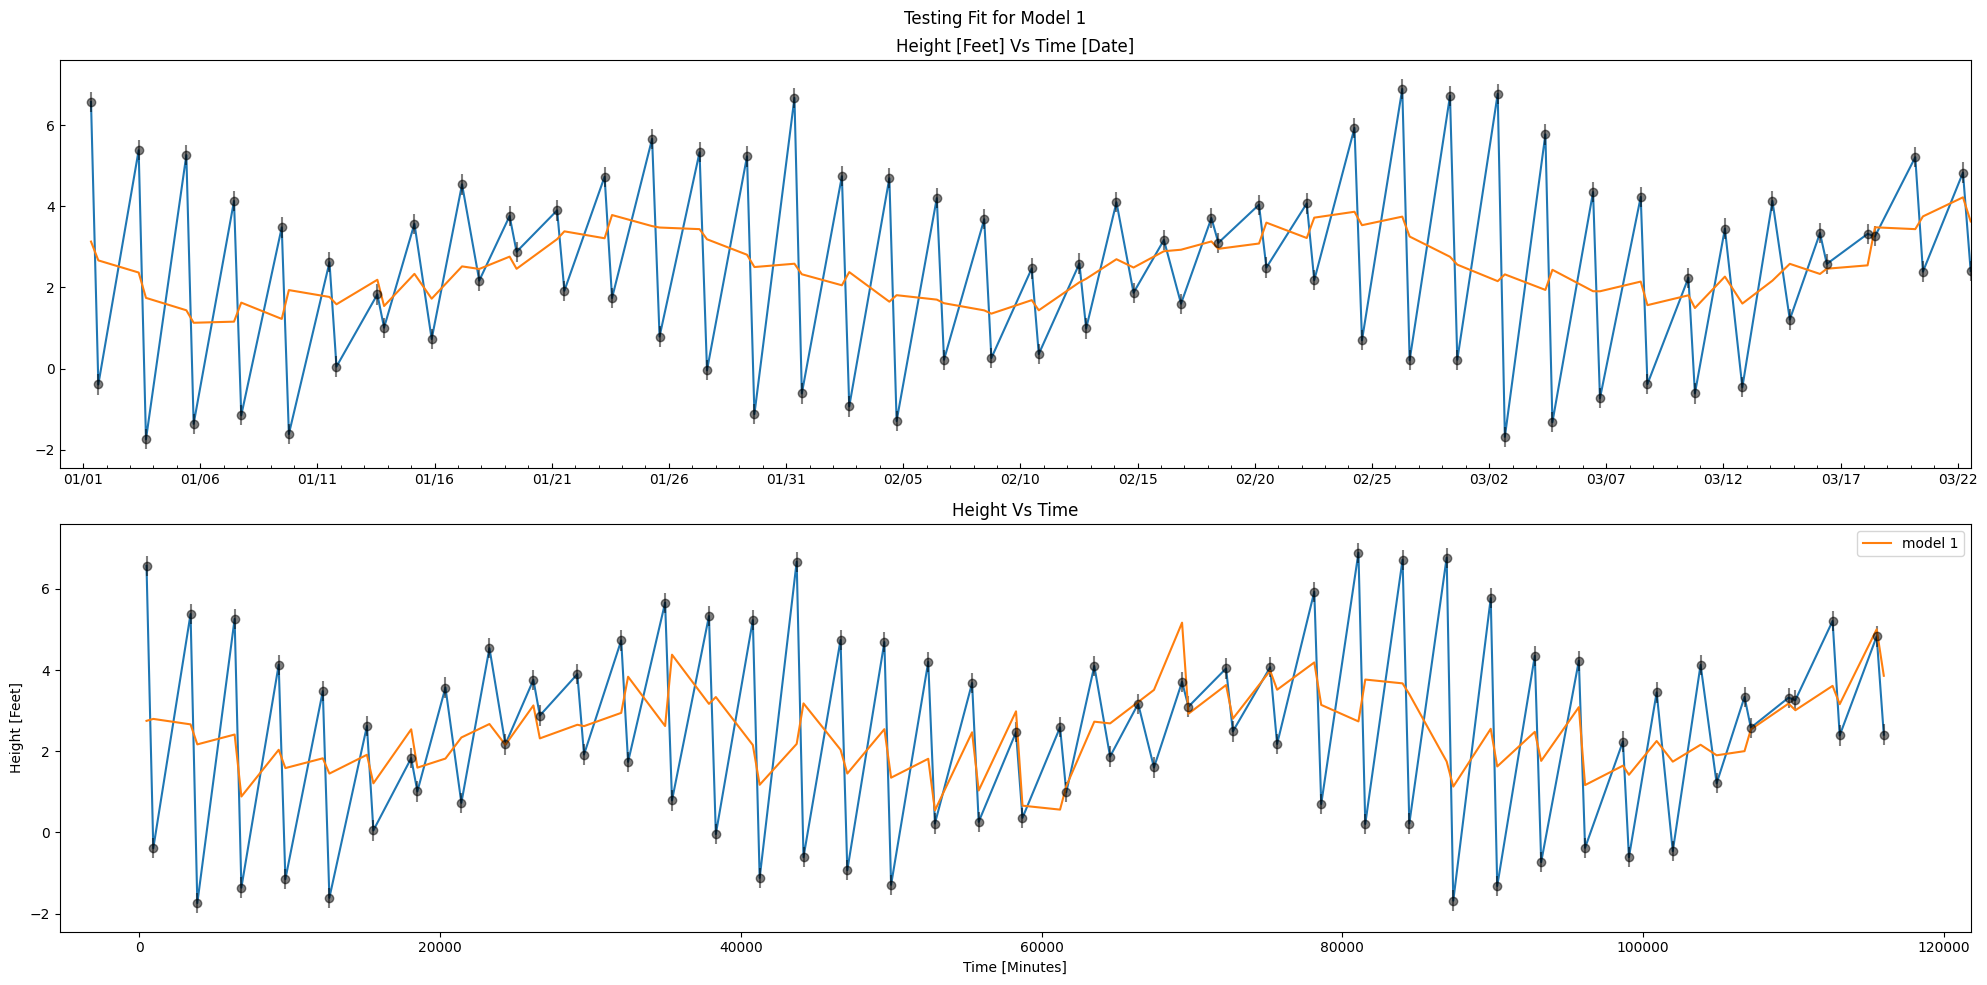

In [109]:
%matplotlib inline

import matplotlib.dates as mdates
from datetime import datetime,timedelta

fig,ax = plt.subplots(2,1,figsize=(20,10), )

fig.suptitle('Testing Fit for Model 1')
mod_1_height =func1(timedata,*params1)

#pick start time
start_time = datetime(2022,1,1,0,0)
# for each minute data point, offset start date by that many minutes
datedata = [start_time + timedelta(minutes=m) for m in np.astype(timedata,type(int))] 
# create and use format for major ticks. See: https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
date_major_format = mdates.DateFormatter('%m/%d')
ax[0].xaxis.set_major_formatter(date_major_format)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=5,))
# create and use format for minor ticks. See: https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
ax[0].set_xlim(start_time-timedelta(days=1),datedata[-1])


ax[0].set_title('Height [Feet] Vs Time [Date]')
ax[0].plot(datedata,heightdata)
ax[0].errorbar(datedata,heightdata,height_err,fmt='o',alpha=0.5,color='black')
ax[0].plot(datedata,mod_1_height, label = 'model 1')

ax[1].set_title('Height Vs Time')
ax[1].plot(timedata,heightdata)
ax[1].errorbar(timedata,heightdata,height_err,fmt='o',alpha=0.5,color='black')
ax[1].plot(timedata,func2(timedata,*params2), label = 'model 1')
ax[1].set_xlabel('Time [Minutes]')
ax[1].set_ylabel('Height [Feet]')

# moving ticks to inside axes
ax[0].tick_params(axis='both',which='both',direction='in',)
ax[0].tick_params(axis='both',which='both',direction='in',)

plt.tight_layout()
plt.legend()
plt.show()
fig.savefig('testbed.png',bbox_inches = 'tight',dpi = 300)

In [110]:
# days = np.array([i for i in range(daydata.min(), daydata.max()+1)])
# height_max_daily = np.array([-99. for i in range(daydata.min(), daydata.max()+1)])
# height_min_daily = np.array([99. for i in range(daydata.min(), daydata.max()+1)])
# for (day,height) in zip(daydata,heightdata):
#     if height > height_max_daily[day]:
#         height_max_daily[day] = height
# for (day,height) in zip(daydata,heightdata):
#     if height < height_min_daily[day]:
#         height_min_daily[day] = height

# def func3(t,a1,f1,b1,a2,f2,b2,c):
#     return a1*np.sin(f1*t + b1) + a2*np.sin(f2*t + b2) + c
# p3 = [6, np.pi/7.5, 0., 1, np.pi/2., .1, 4.5]
# params3,_ = optimize.curve_fit(func3,days,height_max_daily,p0=p3)
# model3 = func3(days,*params3)

# plt.plot(days,height_max_daily,label = 'High Tides')
# plt.plot(days,model3,label = 'High Tides model')
# plt.plot(days,height_min_daily,label = 'Low Tides')
# plt.xlabel('Day')
# plt.ylabel('Height [Feet]')
# plt.title('High and Low Tides per Day')
# plt.legend()

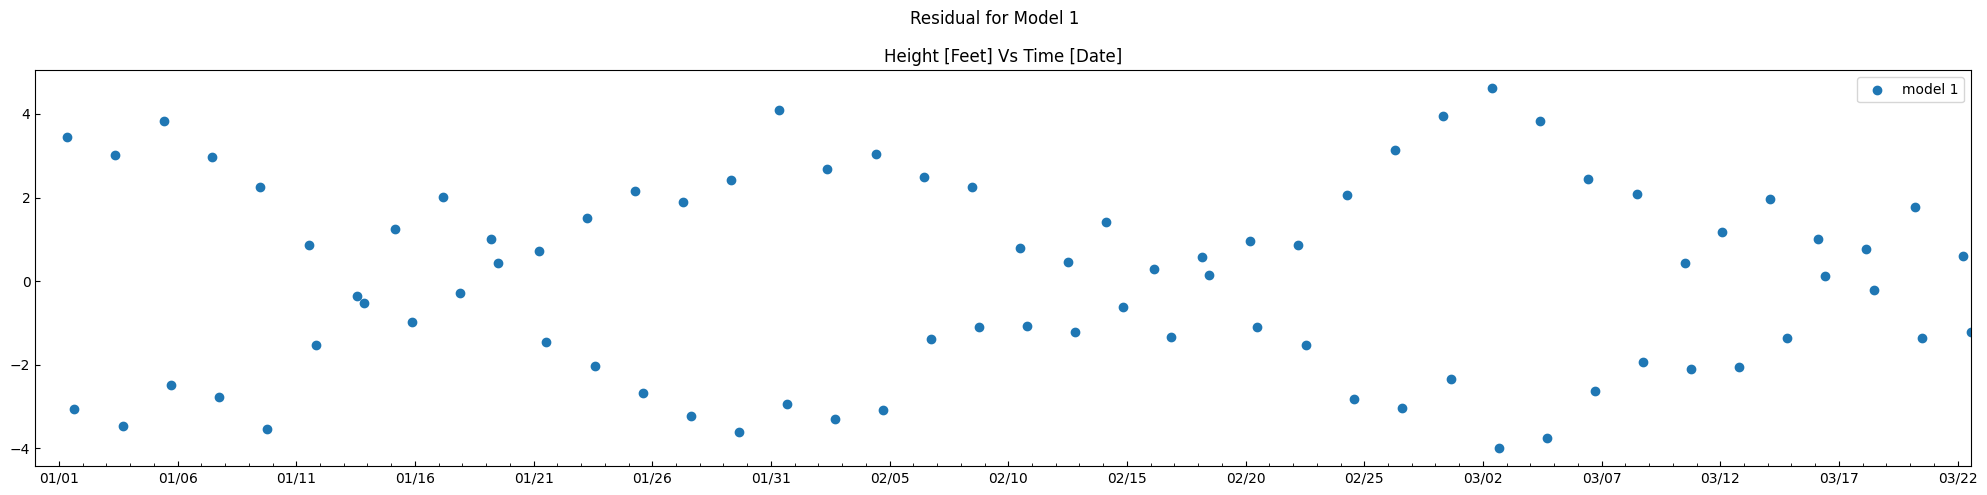

In [111]:
%matplotlib inline

import matplotlib.dates as mdates
from datetime import datetime,timedelta

mod_1_height = func1(timedata,*params1)
residuals = heightdata - mod_1_height
fig,ax = plt.subplots(1,1,figsize=(20,5))

fig.suptitle('Residual for Model 1')

#pick start time
start_time = datetime(2022,1,1,0,0)
# for each minute data point, offset start date by that many minutes
datedata = [start_time + timedelta(minutes=m) for m in np.astype(timedata,type(int))] 
# create and use format for major ticks. See: https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
date_major_format = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_major_format)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5,))
# create and use format for minor ticks. See: https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.set_xlim(start_time-timedelta(days=1),datedata[-1])
# plt.Axes.yaxis.set_minor_locator()


ax.set_title('Height [Feet] Vs Time [Date]')
# ax.plot(datedata,heightdata)
# ax.errorbar(datedata,heightdata,height_err,fmt='o',alpha=0.5,color='black')
# modelx = np.linspace(datedata.min(),datedata.max(),1000)
# ax.plot(modelx,model1(modelx))
ax.scatter(datedata,residuals, label = 'model 1')
# ax.plot(timedata,model2(timedata,*params2), label = 'model 2')

# moving ticks to inside axes
ax.tick_params(axis='both',which='both',direction='in',)
ax.tick_params(axis='both',which='both',direction='in',)

plt.tight_layout()
plt.legend()
plt.show()
fig.savefig('testbed.png',bbox_inches = 'tight',dpi = 300)

Text(0.5, 1.0, 'Histogram of Residuals')

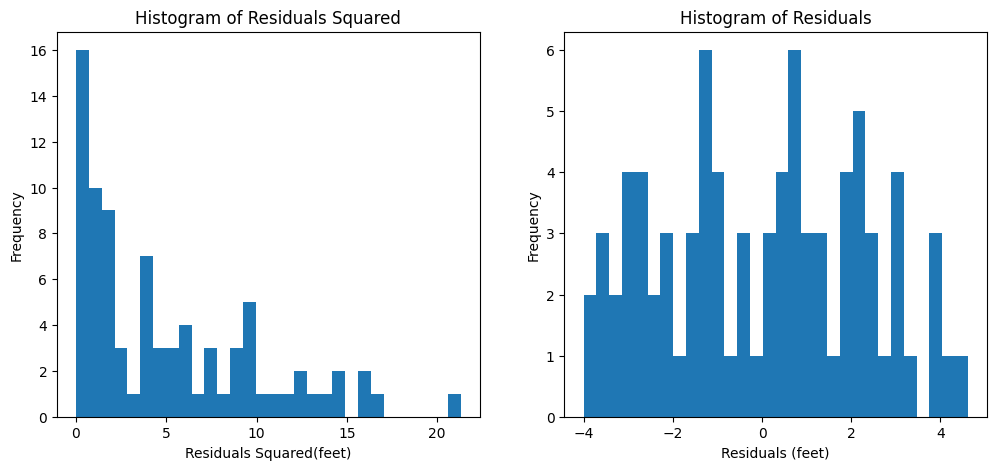

In [112]:
residuals_squared = residuals**2 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(residuals_squared, bins=30)
axes[0].set_xlabel('Residuals Squared(feet)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Residuals Squared')

axes[1].hist(residuals, bins=30)
axes[1].set_xlabel('Residuals (feet)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Residuals')

In [113]:
#Standard deviation of Residual
res_std = np.std(residuals)

In [ ]:
res_mean = np.mean(residuals) 
print(f"Residuals mean: {res_mean}.")
print(f"Residuals std: {res_std}.")

Residuals mean: -5.3941713941103155e-08.
Residuals std: 2.2551499774341788.
